## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import random
import numpy as np
import requests
import os
from tqdm import tqdm


import matplotlib.pyplot as plt

%matplotlib inline

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

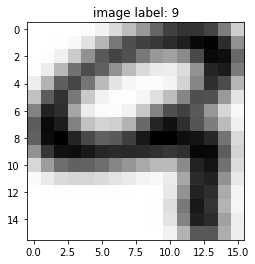

In [5]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [6]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 10)# Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        outputs = F.softmax(self.l1(inputs), dim=1)# Use softmax as the activation function for the last layer
        
        return outputs

In [7]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [9]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0885
Epoch [2/10], Loss: 0.0847
Epoch [3/10], Loss: 0.0811
Epoch [4/10], Loss: 0.0779
Epoch [5/10], Loss: 0.0751
Epoch [6/10], Loss: 0.0726
Epoch [7/10], Loss: 0.0703
Epoch [8/10], Loss: 0.0681
Epoch [9/10], Loss: 0.0661
Epoch [10/10], Loss: 0.0641


Text(0.5, 1.0, 'Visualization of convergence')

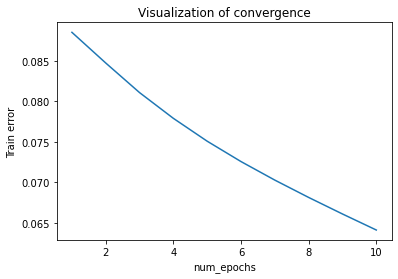

In [10]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [16]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
        result = correct.item()/ len(dataset)
        
    return result
    # print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [12]:
accuracy(val_set, model)

Accuracy of the model : 59.64 %


Text(0.5, 1.0, 'Prediction label: 7')

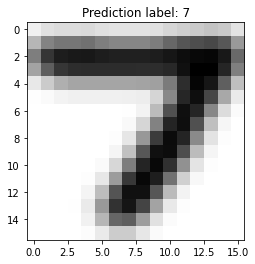

In [13]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

In [44]:
def preprocess(dataset, test_split=0.2, val_split=0.2):
    # Splitting the dataset
    test_size = int(len(dataset)*test_split)
    val_size = int(len(dataset)*val_split)
    train_size = len(dataset) - test_size - val_size
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set

In [81]:
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self, model, label_reshaper=None):
        super().__init__()
        self.model = model
        self.label_reshaper = label_reshaper

    def forward(self, x):
        output = self.model(x)
        return output

    def predict(self, dataset):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        predictions = self.forward(X)
        return predictions

    def evaluate(self, dataset, metrics):
        self.eval()
        X, y = iter(DataLoader(dataset, batch_size=len(dataset))).next()
        if self.label_reshaper:
                    y = self.label_reshaper(y)
        y_hat = self.forward(X)
        results = [metric[1](y, y_hat) for metric in metrics]
        return results

    def fit(self, train_set, val_set, loss_function, optimizer, metrics, num_epochs=20, batch_size=32, shuffle=True, verbose=5):

        # Defining the loaders
        train_loader = DataLoader(train_set, batch_size=batch_size)        
        
        loss_log = []
        val_loss_log = []
        metrics_logs = [[] for metric in metrics]
        val_metrics_logs = [[] for metric in metrics]

        # B-Training
        for epoch in range(num_epochs):
            # Training
            self.train()
            for x, y in train_loader:
                if self.label_reshaper:
                    y = self.label_reshaper(y)
                optimizer.zero_grad()
                y_hat = self.forward(x)
                loss = loss_function(y_hat, y)
                loss.backward()
                optimizer.step()
            
            # Logs
            self.eval()
            ## training set logs
            x, y = iter(DataLoader(train_set, batch_size=len(train_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y)
            loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                metrics_logs[idx].append(metric[1](y, y_hat)) 
                        
            ## validation set logs
            x, y = iter(DataLoader(val_set, batch_size=len(val_set))).next()
            if self.label_reshaper:
                    y = self.label_reshaper(y)
            y_hat = self.forward(x)
            loss = loss_function(y_hat, y)
            val_loss_log.append(loss.item())
            for idx, metric in enumerate(metrics):
                val_metrics_logs[idx].append(metric[1](y, y_hat))
            
            # Print logs
            if verbose and (epoch+1)%verbose == 0 or epoch==0:
                print("epoch: ", epoch+1)
                print("Training Loss: ", loss_log[epoch])
                print("Validation Loss: ", val_loss_log[epoch])
                for idx, metric in enumerate(metrics):
                    print(f"Training {metric[0]}: {metrics_logs[idx][epoch]}")
                    print(f"Validation {metric[0]}: {val_metrics_logs[idx][epoch]}")
        
        return loss_log, val_loss_log, metrics_logs, val_metrics_logs

In [94]:
def run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=0, val_split=0.2, num_epochs=20, lr=0.01, batch_size=32, shuffle=True, verbose=5, initializer=None, label_reshaper=None):
    # Prepare dataset
    train_set, val_set, test_set = preprocess(dataset, test_split=test_split, val_split=val_split)

    # Instanciating the model
    model = Model(model, label_reshaper)

    # Applying weight initialization should the method be supplied
    if initializer is not None:
        model.apply(initializer)
        if verbose:
            print("Applied weight initialization")
    
    # Training the model
    loss_log, val_loss_log, metrics_logs, val_metrics_logs = model.fit(train_set, val_set, loss_function=loss_function, optimizer=optimizer, metrics=metrics, num_epochs=num_epochs, batch_size=batch_size, shuffle=shuffle, verbose=verbose)

    # Plotting results
    epoch_range = np.arange(num_epochs, dtype=int) + 1

    # Compute the number of rows for plotting the results given that we want 3 columns max per row
    n_metrics = len(metrics)
    n_columns = max(2, min(n_metrics, 3))
    n_rows = int(n_metrics / n_columns) + 1
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns, squeeze=False, figsize=(12,8))
    fig.tight_layout()

    walk = -1
    for ir, row in enumerate(ax):
        for ic, col in enumerate(row):
            if walk == -1: # loss function
                col.plot(epoch_range, loss_log, 'ro-', label='Training Loss')
                col.plot(epoch_range, val_loss_log, 'bx--', label='Validation Loss')
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel("Loss")
            elif walk < n_metrics:
                col.plot(epoch_range, val_metrics_logs[walk], 'ro-', label='Training '+metrics[walk][0])
                col.plot(epoch_range, val_metrics_logs[walk], 'bx--', label='Validation '+metrics[walk][0])
                col.legend()
                col.set_xlabel("Epoch")
                col.set_ylabel(metrics[walk][0])
            else:
                ax[ir, ic].axis('off')
                continue
            walk += 1
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

    # Evaluate model
    if len(test_set) > 0:
        results = model.evaluate(test_set, metrics)

        # Print test evaluation results
        for i, metric in enumerate(metrics):
            print(f"Test {metrics[i][0]}: ", "%.2f" % round(results[i], 2))
        
        # # Plot one test example
        # test_index = random.choice(np.arange(0, len(test_set)))

        # input, label = test_set[test_index]
        # input = input.view(1, *input.shape)
        # label = torch.tensor([label])
        # if label_reshaper:
        #     label = label_reshaper(label)
        # prediction = model(input).detach().squeeze()
        # prediction = prediction.argmax(dim=-1).item()
        # plt.imshow(input.view(input.shape[-2], input.shape[-1]), cmap=plt.cm.gray_r, interpolation='nearest')
        # plt.title("Prediction label: %d" % prediction)
    

    elif len(val_set) > 0:
        results = model.evaluate(val_set, metrics)

        # Print validation evaluation results
        for i, metric in enumerate(metrics):
            print(f"Validation {metrics[i][0]}: ", "%.2f" % round(results[i], 2))

    return model


In [66]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, input):
        '''
        Reshapes the input according to the shape saved in the view data structure.
        '''
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape)
        return out

In [90]:
def accuracy(y, y_hat):
    if len(y.shape) >= 2 and y.shape[1] > 1:
        _, real = torch.max(y, 1) 
        _, pred = torch.max(y_hat, 1) 
        correct = (pred == real).sum()
    else:
        _, pred = torch.max(y_hat, 1)
        correct = (pred == y).sum()

    result = correct.item()/ len(y)
    return result

In [91]:
# Global config
val_split=0.2
test_split=0
shuffle=True
initializer=None
metrics = [("Accuracy", accuracy)]

In [69]:
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

Linear classifier

epoch:  1
Training Loss:  0.08993273228406906
Validation Loss:  0.08981440216302872
Training Accuracy: 0.3070461169209669
Validation Accuracy: 0.3045267489711934
epoch:  30
Training Loss:  0.050263453274965286
Validation Loss:  0.0507870614528656
Training Accuracy: 0.7803874507114692
Validation Accuracy: 0.7695473251028807
epoch:  60
Training Loss:  0.03912706300616264
Validation Loss:  0.03969024866819382
Training Accuracy: 0.8618206754671696
Validation Accuracy: 0.8539094650205762
epoch:  90
Training Loss:  0.035542476922273636
Validation Loss:  0.036103520542383194
Training Accuracy: 0.8822218412480713
Validation Accuracy: 0.8751714677640604


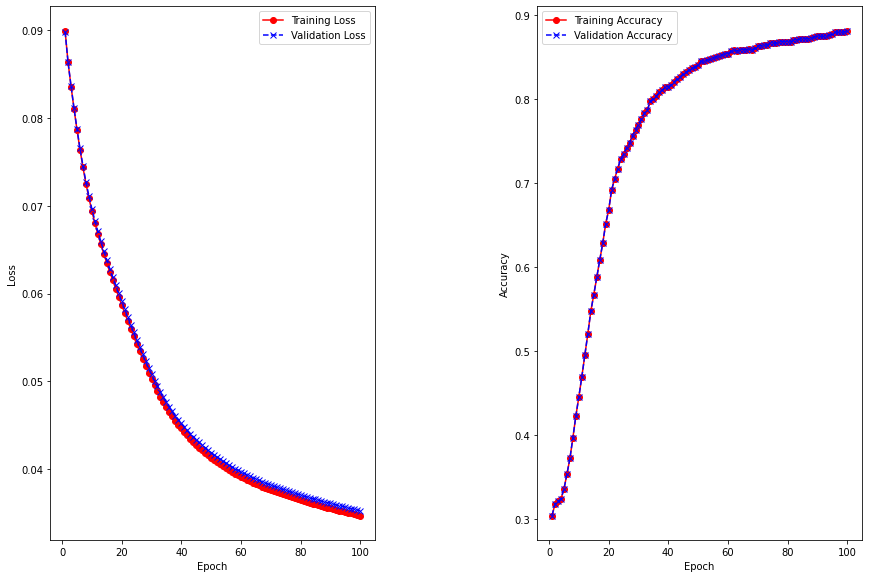

Validation Accuracy:  0.88


In [74]:
# model
dim = 16*16
hidden_dim = 10
model = nn.Sequential(
    View((dim,)),
    nn.Linear(dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, 128),
    nn.Tanh(),
    nn.Linear(128, 10))

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


Convolutional layers

In [ ]:
# Function computing the output size of convolutional and pooling layers
def out_size(h_in, kernel_size, padding=0, stride=1, dilatation=1):
    h_out = ((h_in + 2*padding - dilatation*(kernel_size-1) - 1)/ stride) + 1
    h_out = int(h_out)
    return h_out

epoch:  1
Training Loss:  0.09881584346294403
Validation Loss:  0.0988980159163475
Training Accuracy: 0.0781758957654723
Validation Accuracy: 0.08024691358024691
epoch:  30
Training Loss:  0.08707558363676071
Validation Loss:  0.08715475350618362
Training Accuracy: 0.2988170752614435
Validation Accuracy: 0.3045267489711934
epoch:  60
Training Loss:  0.07843326777219772
Validation Loss:  0.07856661826372147
Training Accuracy: 0.3631064632264701
Validation Accuracy: 0.3607681755829904
epoch:  90
Training Loss:  0.06412403285503387
Validation Loss:  0.06402987986803055
Training Accuracy: 0.5119149665695183
Validation Accuracy: 0.50960219478738


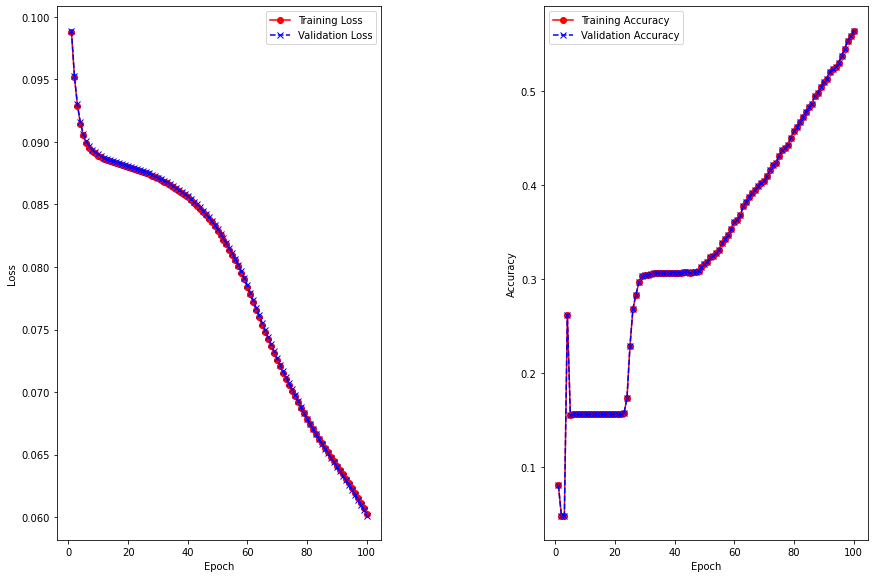

Validation Accuracy:  0.56


In [75]:
# model
model = nn.Sequential(
    nn.Conv2d(1, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(3, 5, 2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    View((5*3*3,)),
    nn.Linear(45, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10))

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


Let's try with fewer layers and use a Tanh activation

epoch:  1
Training Loss:  0.0947381928563118
Validation Loss:  0.09479165822267532
Training Accuracy: 0.16320932624721413
Validation Accuracy: 0.16666666666666666
epoch:  30
Training Loss:  0.0564398467540741
Validation Loss:  0.057071976363658905
Training Accuracy: 0.694325390022287
Validation Accuracy: 0.6817558299039781
epoch:  60
Training Loss:  0.04334114119410515
Validation Loss:  0.04435453936457634
Training Accuracy: 0.8361049202811589
Validation Accuracy: 0.836076817558299
epoch:  90
Training Loss:  0.03889584168791771
Validation Loss:  0.039974283427000046
Training Accuracy: 0.8643922509857707
Validation Accuracy: 0.8717421124828533


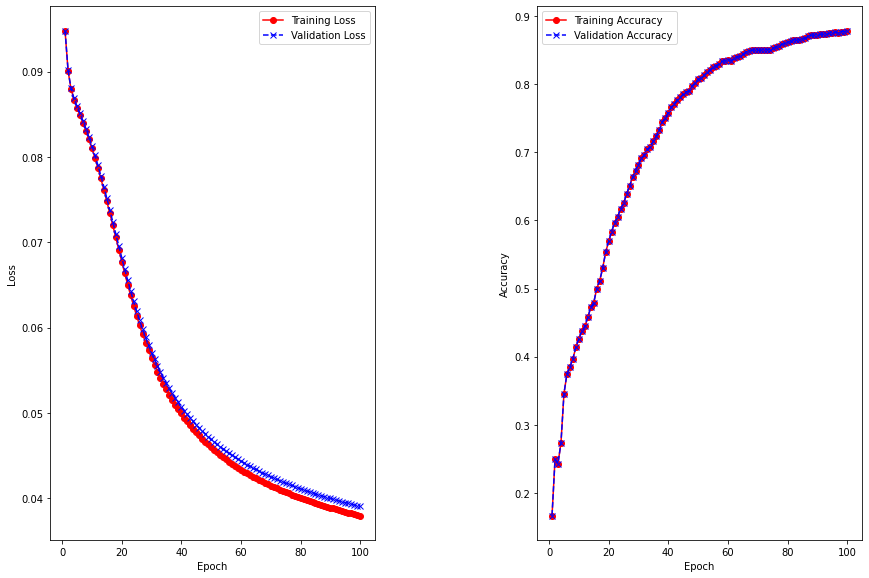

Validation Accuracy:  0.88


In [76]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 64
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

Batch size = 10, lr = 0.01

epoch:  1
Training Loss:  0.07579550892114639
Validation Loss:  0.07626853138208389
Training Accuracy: 0.46511229213097893
Validation Accuracy: 0.47050754458161864
epoch:  30
Training Loss:  0.033184561878442764
Validation Loss:  0.03454165533185005
Training Accuracy: 0.8938796502657295
Validation Accuracy: 0.877914951989026
epoch:  60
Training Loss:  0.025998162105679512
Validation Loss:  0.027477849274873734
Training Accuracy: 0.9192525287159267
Validation Accuracy: 0.9074074074074074
epoch:  90
Training Loss:  0.02119637094438076
Validation Loss:  0.02272350713610649
Training Accuracy: 0.934681981827533
Validation Accuracy: 0.9218106995884774


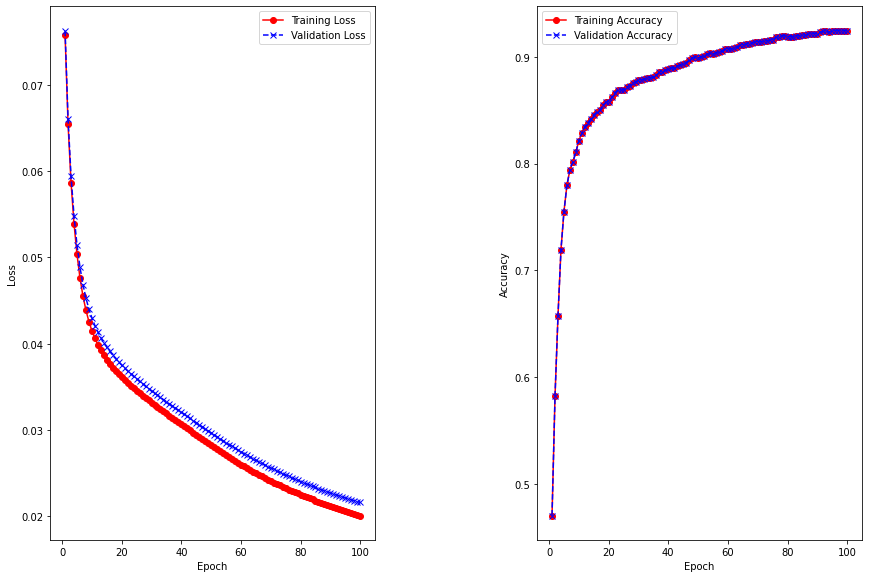

Validation Accuracy:  0.92


In [77]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 10
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=None
verbose=30    

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


Batch size = 256, lr =0.1

epoch:  1
Training Loss:  0.10932067036628723
Validation Loss:  0.1089853048324585
Training Accuracy: 0.15463740785187724
Validation Accuracy: 0.16392318244170095
epoch:  30
Training Loss:  0.07566727697849274
Validation Loss:  0.07536190748214722
Training Accuracy: 0.42602434424824276
Validation Accuracy: 0.42592592592592593
epoch:  60
Training Loss:  0.0649971291422844
Validation Loss:  0.06504921615123749
Training Accuracy: 0.5489456540373736
Validation Accuracy: 0.5411522633744856
epoch:  90
Training Loss:  0.05789901688694954
Validation Loss:  0.05836421623826027
Training Accuracy: 0.6490656608949082
Validation Accuracy: 0.6344307270233196


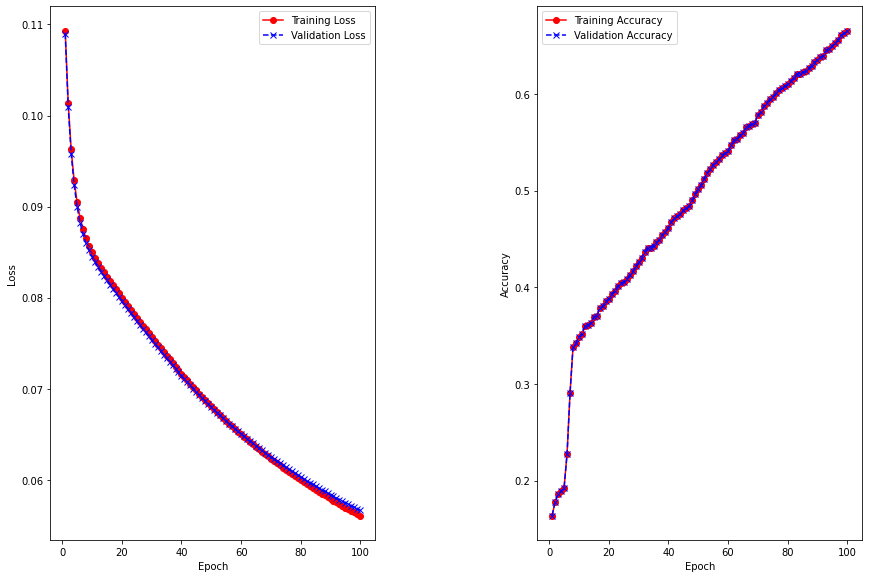

Validation Accuracy:  0.67


In [78]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 256
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


mini-conclusion: Increasing the learning rate causes the model to learn faster compared to the previous experiments. Moreover the smaller the batch size the better the model learns for the smae number of epochs. However decreasing the batch size lengthens the training.

Let's now try Adam optimizer

epoch:  1
Training Loss:  0.031652066856622696
Validation Loss:  0.03138309717178345
Training Accuracy: 0.9103377335847763
Validation Accuracy: 0.9183813443072703
epoch:  30
Training Loss:  0.008986911736428738
Validation Loss:  0.011159859597682953
Training Accuracy: 0.9783987656437511
Validation Accuracy: 0.96639231824417
epoch:  60
Training Loss:  0.00835972186177969
Validation Loss:  0.01198931410908699
Training Accuracy: 0.982341848105606
Validation Accuracy: 0.9636488340192044
epoch:  90
Training Loss:  0.008429201319813728
Validation Loss:  0.012227230705320835
Training Accuracy: 0.9792559574832848
Validation Accuracy: 0.9595336076817559


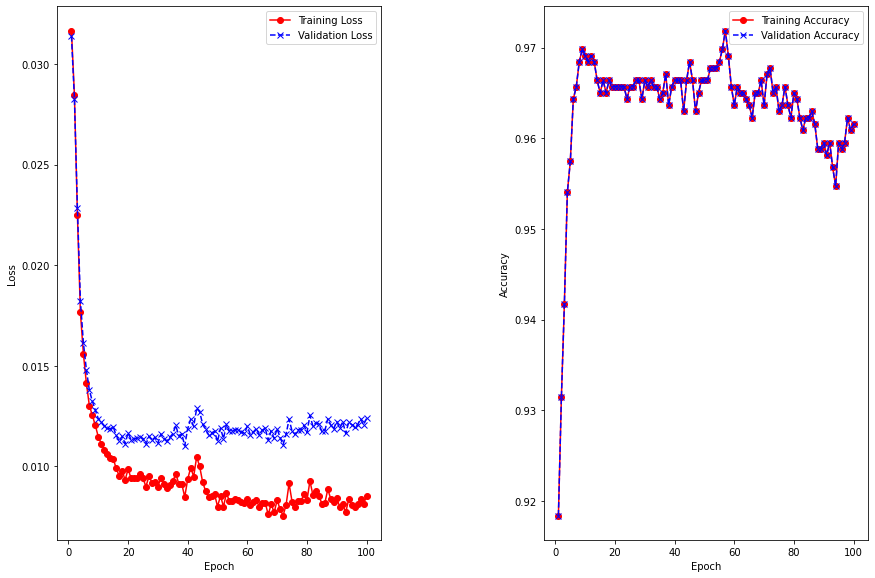

Validation Accuracy:  0.96


In [79]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

def one_hot_reshaper(labels):
    # One-hot encoding or labels so as to calculate MSE error:
    labels_one_hot = torch.FloatTensor(len(labels), 10)
    labels_one_hot.zero_()
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
    return labels_one_hot

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=one_hot_reshaper)


Adam optimizer yield a significantly better performance than SGD as the experiment in the previous cell showed it.

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

epoch:  1
Training Loss:  0.19392149150371552
Validation Loss:  0.20114509761333466
Training Accuracy: 0.9449682839019372
Validation Accuracy: 0.9423868312757202
epoch:  30
Training Loss:  0.007379792630672455
Validation Loss:  0.13508599996566772
Training Accuracy: 0.9979427395851191
Validation Accuracy: 0.9705075445816187
epoch:  60
Training Loss:  0.00636914512142539
Validation Loss:  0.14481288194656372
Training Accuracy: 0.9993142465283731
Validation Accuracy: 0.9732510288065843
epoch:  90
Training Loss:  0.014122300781309605
Validation Loss:  0.19140049815177917
Training Accuracy: 0.9955426024344248
Validation Accuracy: 0.967764060356653


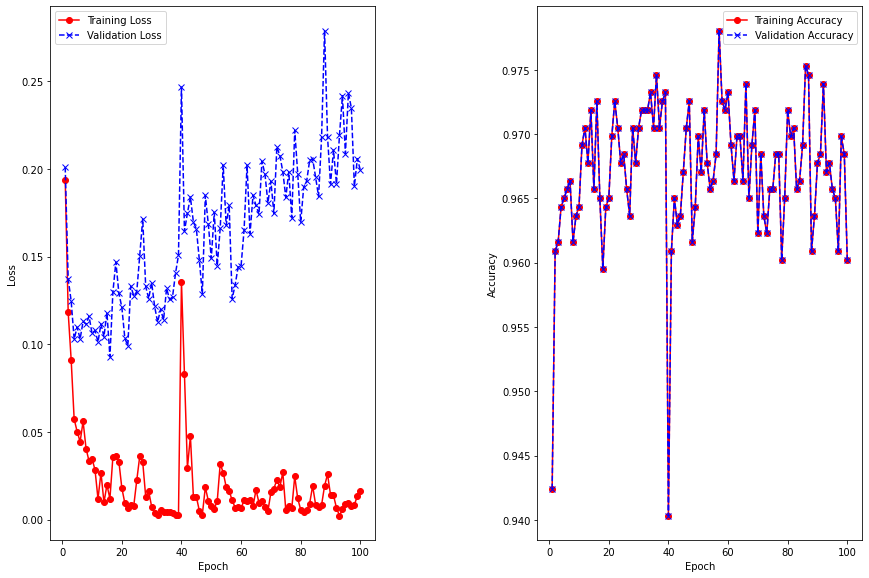

Validation Accuracy:  0.96


In [93]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 32
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

# def label_reshaper(y):
#     return y.reshape(-1, 1)

#run experiment
run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [97]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [98]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

epoch:  1
Training Loss:  0.2079942673444748
Validation Loss:  0.21721775829792023
Training Accuracy: 0.9389679410252014
Validation Accuracy: 0.9423868312757202
epoch:  30
Training Loss:  0.007116776425391436
Validation Loss:  0.18957385420799255
Training Accuracy: 0.9981141779530259
Validation Accuracy: 0.9691358024691358
epoch:  60
Training Loss:  0.0011993559310212731
Validation Loss:  0.2255496382713318
Training Accuracy: 0.9998285616320932
Validation Accuracy: 0.9657064471879286
epoch:  90
Training Loss:  2.2245681975618936e-05
Validation Loss:  0.2318391054868698
Training Accuracy: 1.0
Validation Accuracy: 0.9670781893004116


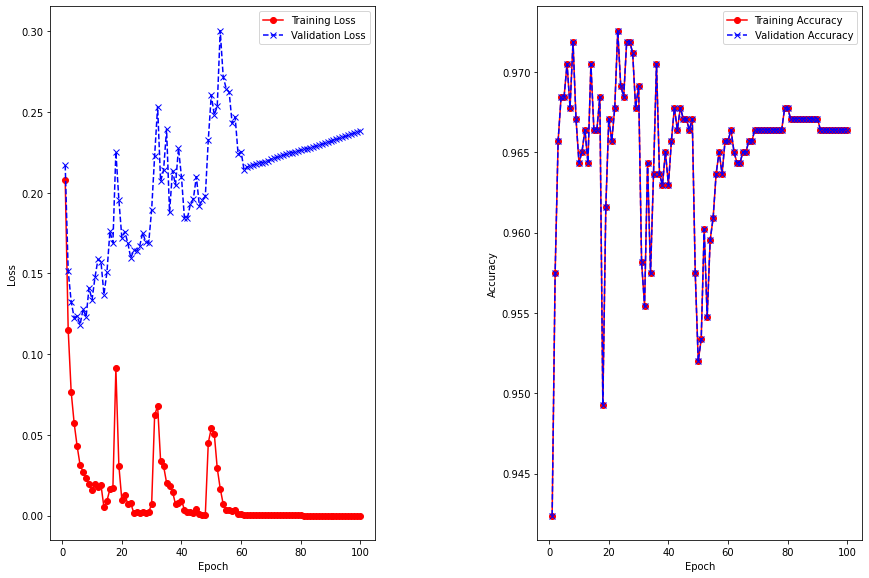

Validation Accuracy:  0.97


In [95]:
model = nn.Sequential(
    nn.Conv2d(1, 3, 4),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    View((3*6*6,)),
    nn.Linear(3*6*6, 64),
    nn.Tanh(),
    nn.Linear(64, 10))

num_epochs = 100
batch_size = 32
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
label_reshaper=None
verbose=30

# def label_reshaper(y):
#     return y.reshape(-1, 1)

#run experiment
final_model = run_experiment(model, dataset, loss_function, optimizer, metrics, test_split=test_split, val_split=val_split, num_epochs=num_epochs, lr=lr, batch_size=batch_size, shuffle=True, verbose=verbose, initializer=None, label_reshaper=label_reshaper)


In [101]:
results = final_model.evaluate(test_set, metrics)
for i, metric in enumerate(metrics):
    print(f"Test {metric[0]}:", results[i])

Test Accuracy: 0.9307424015944196
